# Predicting Heart Disease based on Cleveland's Dataset

Group 11: Rui Xiang Yu, Laurent Mbabazi & Dilay Aykut

## 1. Introduction

Heart disease is a broad term that encompasses medical conditions that primarily affect coronary arteries, heart rhythm, and the heart's health. Heart disease is a serious condition and it is the leading cause of death in the United States according to the Centers of Disease Control and Prevention (2020). It is notoriously hard to diagnose due to the requirement of several variables needing to simultaneously point towards the same conclusion.

The Cleveland Heart Disease Dataset found on the UCI Machine Learning Repository comprises information on 303 individuals (206 men and 97 women), with an age range of 29 to 77 and 14 variables. Our original predictive question was what is a person's heart diagnosis based on their age, sex, ST depression induced by exercise, number of major vessels, maximum heart rate, and fasting blood sugar. The main aim is to have a model that is as accurate as possible given the heavy implications of a misdiagnosis.

## 2. Methods & Results

### 2.1. Loading and tidying data

The first step will be loading all necessary libraries. Then, the dataset is loaded from the internet. Finally, the dataset is tidied.

In [1]:
# Loading the libraries.
library(tidyverse)
library(tidymodels)
library(dplyr)
library(readr)
library(cowplot)
library(recipes)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
#Loading data into R, selecting interested columns and previewing first 6 rows.
heart <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                  col_names = c("age", "sex", "chestpaintype", "restbps", 
                                "cholesterolserum", "fastingbs", "restecg",
                                "maxheartrate", "exerciseangina", "oldpeak",
                                "slope", "nmajorvessels", "thalassemia", 
                                "diagnosis"))                               %>%
         mutate(diagnosis = as_factor(diagnosis))                           %>%
         select(age, sex, oldpeak, nmajorvessels, 
                fastingbs, maxheartrate, diagnosis)

head(heart)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  chestpaintype = col_double(),
  restbps = col_double(),
  cholesterolserum = col_double(),
  fastingbs = col_double(),
  restecg = col_double(),
  maxheartrate = col_double(),
  exerciseangina = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  nmajorvessels = col_character(),
  thalassemia = col_character(),
  diagnosis = col_double()
)



age,sex,oldpeak,nmajorvessels,fastingbs,maxheartrate,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
63,1,2.3,0.0,1,150,0
67,1,1.5,3.0,0,108,2
67,1,2.6,2.0,0,129,1
37,1,3.5,0.0,0,187,0
41,0,1.4,0.0,0,172,0
56,1,0.8,0.0,0,178,0


*Figure 1.1. First six rows of the loaded Cleveland dataset with interested selected columns.*

In this dataset, each variable has the following meaning:
- `age`: age of the person recorded, in years.
- `sex`: biological sex of the person recorded, with 0 meaning female and 1 meaning male.
- `oldpeak`: ST depression induced by exercise relative to rest.
- `nmajorvessels`: the number of major vessels coloured by fluoroscopy, being a value between 0-3.
- `fastingbs`: fasting blood sugar rate in milligrams over deciliter (mg/dl), with 0 meaning under 120 and 1 meaning over 120.
- `maxheartrate`: the maximum heart rate of the person recorded, in beats per minute (BPM).
- `diagnosis`: indication of presence of heart disease, with 0 meaning none and 1-4 meaning there is presence.

In [5]:
#Looking at how many missing values are in each variable:
colSums(is.na(heart))

# However, a closer look shows that nmajorvessels has 4 NA values that should be filtered.
heart_closeup <- heart       %>%
filter(nmajorvessels == "?") %>%
select(nmajorvessels)        %>%
count()
heart_closeup

age           sex       oldpeak nmajorvessels     fastingbs 
            0             0             0             0             0 
 maxheartrate     diagnosis 
            0             0

n
<int>
4


*Figure 1.2. Number of NA values in `nmajorvessels`.*

In [4]:
# Removing the missing data in nmajorvessels
heart_filtered <- heart                           %>%
                  filter(nmajorvessels != "?")

head(heart_filtered)

age,sex,oldpeak,nmajorvessels,fastingbs,maxheartrate,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
63,1,2.3,0.0,1,150,0
67,1,1.5,3.0,0,108,2
67,1,2.6,2.0,0,129,1
37,1,3.5,0.0,0,187,0
41,0,1.4,0.0,0,172,0
56,1,0.8,0.0,0,178,0


*Figure 1.3. First six rows of the Cleveland dataset without NA values.*

In [6]:
# Since values other than 0 for diagnosis means presence of heart disease, 1-4 values are lumped into 1.
# Number of major vessels is converted into numeric. Diagnosis is recoded to ease
# understanding of its values and converted into factors for graphing.
heart_disease <- heart_filtered                                             %>%
                 mutate(diagnosis = fct_lump(diagnosis, other_level = "1")) %>%
                 mutate(nmajorvessels = as.numeric(nmajorvessels))          %>%
                 mutate(diagnosis = recode_factor(diagnosis, `1` = "Yes",
                                                  `0` = "No"))

head(heart_disease)

age,sex,oldpeak,nmajorvessels,fastingbs,maxheartrate,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,2.3,0,1,150,No
67,1,1.5,3,0,108,Yes
67,1,2.6,2,0,129,Yes
37,1,3.5,0,0,187,No
41,0,1.4,0,0,172,No
56,1,0.8,0,0,178,No


*Figure 1.4. First six rows of the clean and tidy, final Cleveland dataset.*

Here is the final, clean and tidy data.

### 2.2. Summary and exploratory data analysis

First, the dataset will be split into a training set and testing set, to be able to perform exploratory data analysis on the training set. A summary table will be produced as an initiator and then more indicative plots will be created.

In [7]:
#Splitting the data and looking at number of rows for each set.
set.seed(11)

heart_split <- initial_split(heart_disease, prop = 0.70, strata = diagnosis)
heart_train <- training(heart_split)
heart_test  <- testing(heart_split)


nrow(heart_train)
nrow(heart_test)

[1] 210

[1] 89

In [8]:
#Looking at the means/ratio of each predictor for each type of diagnosis.
group_summary <- heart_train                                                %>% 
                 group_by(diagnosis)                                        %>% 
                 summarize(size = n(),
                            age_mean = mean(age),
                            maxheartrate_mean = mean(maxheartrate),
                            oldpeak_mean = mean(oldpeak),
                            nmajorvessels_mean = mean(nmajorvessels),
                            sex_fraction_female = sum(sex == "0")/n(),
                            sex_fraction_male = sum(sex == "1")/n(),
                            fastingbs_fraction_over_120 = 
                                             sum(fastingbs == "1")/n(),
                            fastingbs_fraction_under_120 = 
                                             sum(fastingbs == "0")/n())

group_summary

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,size,age_mean,maxheartrate_mean,oldpeak_mean,nmajorvessels_mean,sex_fraction_female,sex_fraction_male,fastingbs_fraction_over_120,fastingbs_fraction_under_120
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Yes,97,57.14433,138.3402,1.535052,1.1855670,0.1134021,0.8865979,0.1340206,0.8659794
No,113,52.23009,159.6726,0.600000,0.2920354,0.4247788,0.5752212,0.1592920,0.8407080


*Figure 2.1. Summary table with the mean values and fractions of each predictor based on the diagnosis.*

In [9]:
#Looking at overall means for numeric predictors.
heart_means <- heart_train                                               %>%
               select(age, maxheartrate, oldpeak, nmajorvessels)         %>%
               map_df(mean)
heart_means

age,maxheartrate,oldpeak,nmajorvessels
<dbl>,<dbl>,<dbl>,<dbl>
54.5,149.819,1.031905,0.7047619


*Figure 2.2. Summary table of the mean values of the numeric predictors.*

Based on figures 2.1 and 2.2, it seems like older people, with low heart rates, high ST depression exercise-induced, high number of observed major vessels and males are more likely to have heart disease. However, it seems that the numbers for fasting blood sugar are quite similar, which might indicate it is not a good predictor. Plotting graphs are generated to help us ascertain this conclusion:

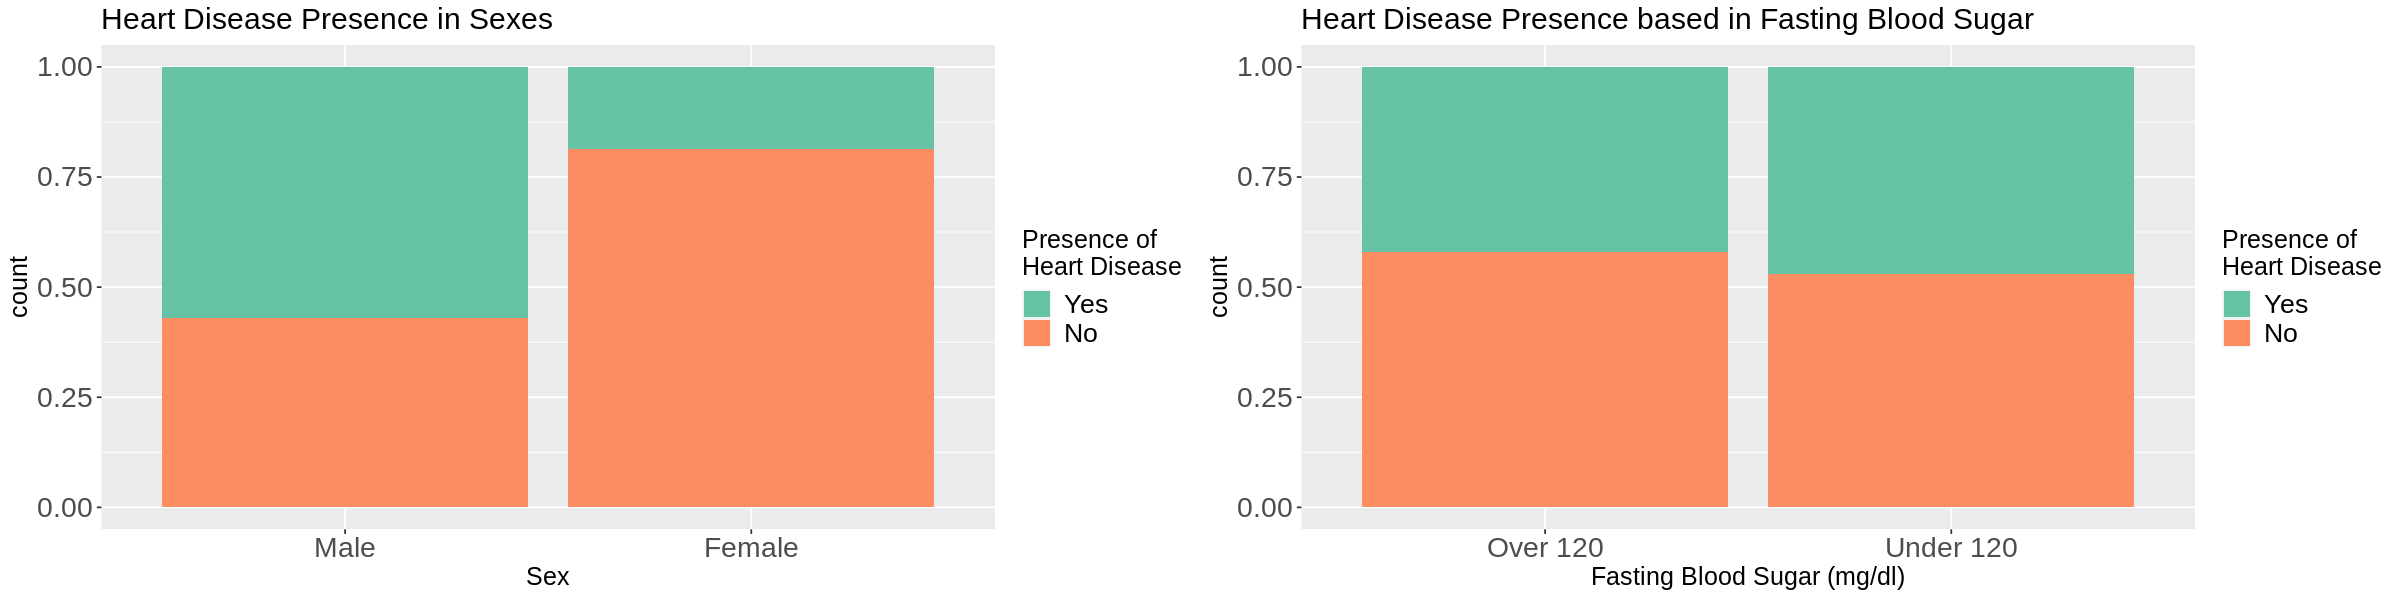

In [10]:
#Visualizing different relevant plots with training data.
options(repr.plot.width = 20, repr.plot.height = 5) 

#Plotting a bar graph looking at presence of heart disease based in the sex.
heart_train_sex <- heart_train %>%
mutate(sex = recode_factor(sex, `1` = "Male",
                           `0` = "Female" ))
sex_plot <- ggplot(heart_train_sex, aes(x = sex, fill = diagnosis))         +
             geom_bar(position = "fill")                                    +
             labs(x = "Sex", fill = "Presence of \nHeart Disease")          +
             ggtitle("Heart Disease Presence in Sexes")                     +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")

# Plotting a bar graph looking at presence of heart disease based on fasting 
# blood sugar level.
heart_train_sugar <- heart_train %>%
mutate(fastingbs = recode_factor(fastingbs, `1` = "Over 120", 
                                 `0` = "Under 120"))
bs_plot  <- ggplot(heart_train_sugar, aes(x = fastingbs, fill = diagnosis)) +
             geom_bar(position = "fill")                                    +
             labs(x = "Fasting Blood Sugar (mg/dl)", 
                  fill = "Presence of \nHeart Disease")                     +
             ggtitle("Heart Disease Presence based in Fasting Blood Sugar") +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")

plot_grid(sex_plot, bs_plot, ncol = 2)

*Figure 2.3. Bar plots on the presence of heart diagnosis based on sex and fasting blood sugar.*

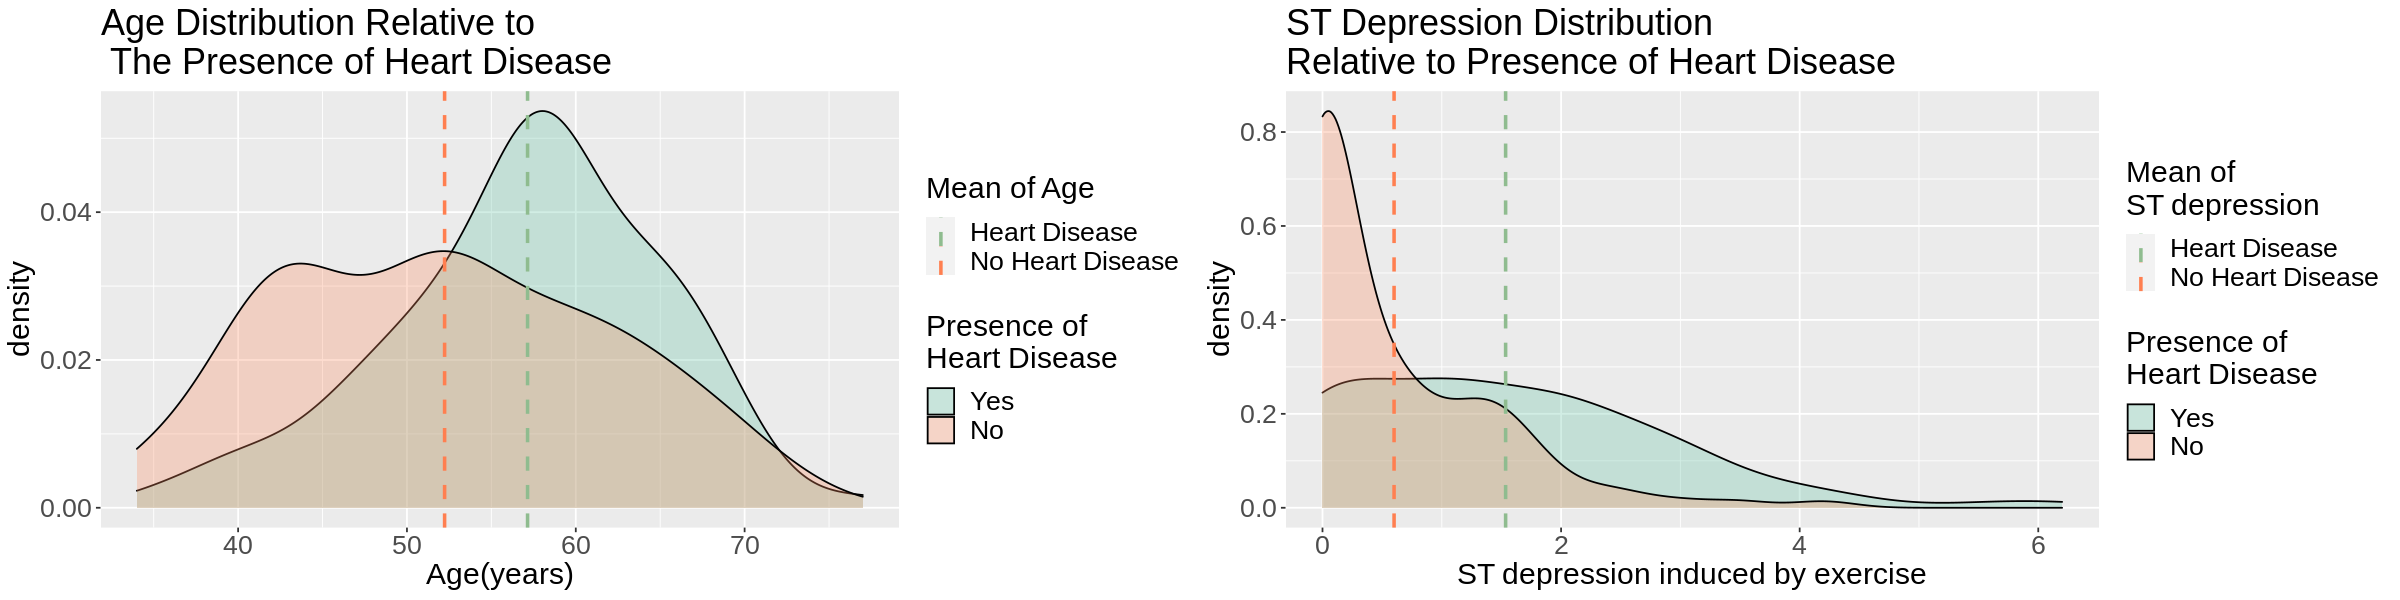

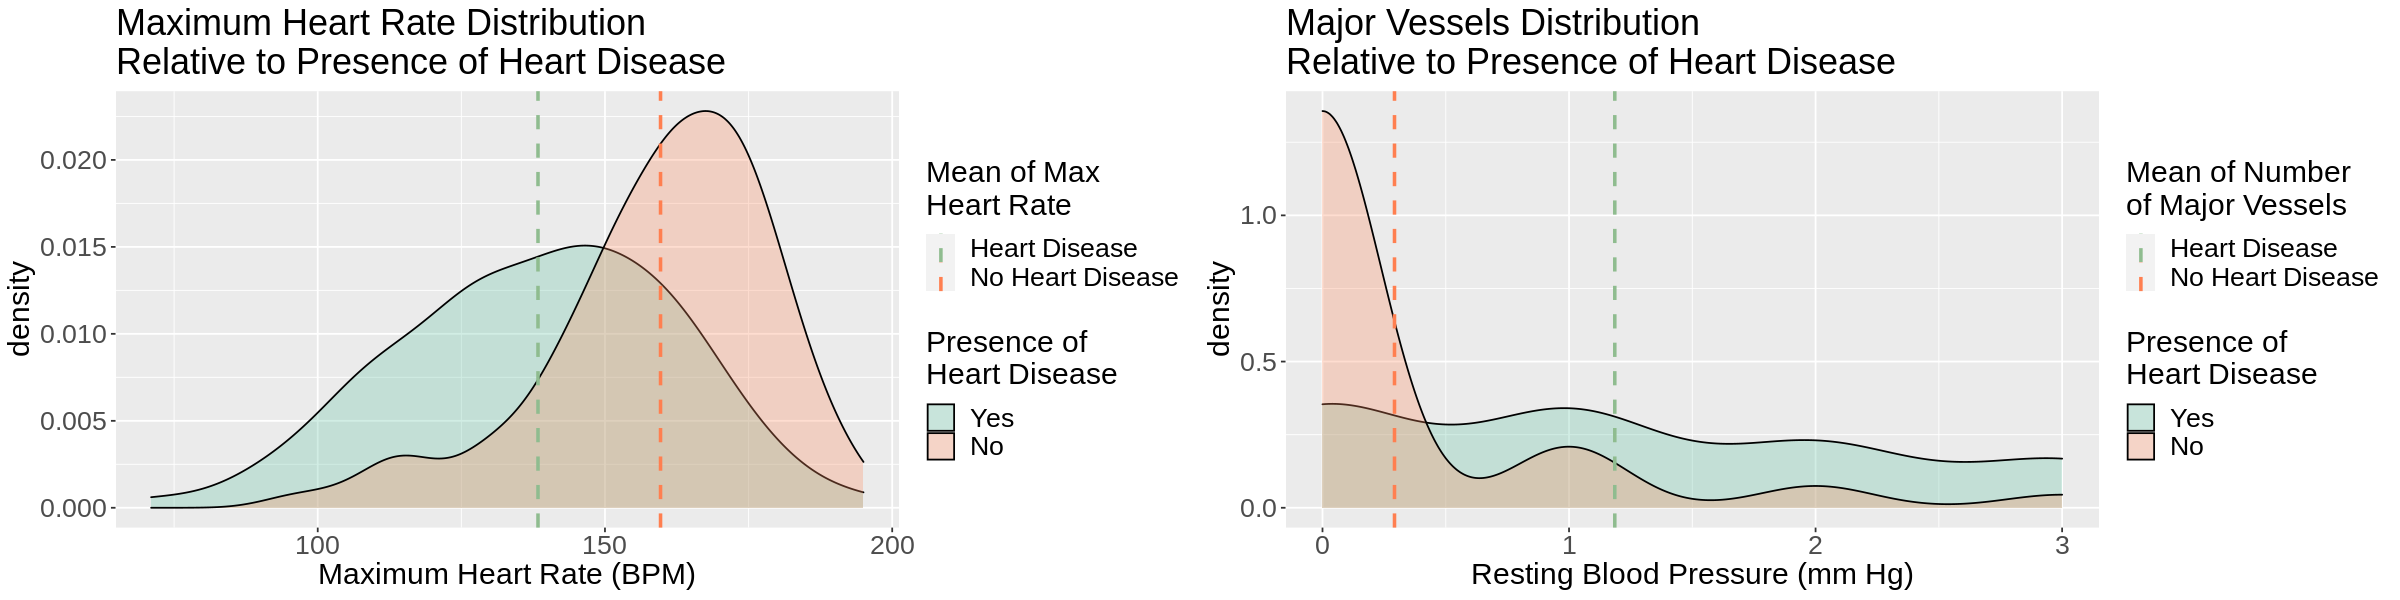

In [13]:
options(repr.plot.width = 20, repr.plot.height = 5) 
#Looking at age distribution
age_plot  <- ggplot(heart_train, aes(x = age, fill = diagnosis))            +
              geom_density(alpha = 0.3)                                     +
              geom_vline(data = group_summary, 
                         aes(xintercept = age_mean, color = diagnosis),
                             linetype = "dashed", size = 1)                 +
              labs(x     = "Age(years)", 
                   fill  = "Presence of \nHeart Disease", 
                   color = "Mean of Age")                                   +
              scale_color_manual(labels = c("Heart Disease", 
                                         "No Heart Disease"),
                                values = c("darkseagreen", "coral"))        +
    ggtitle("Age Distribution Relative to \n The Presence of Heart Disease")+
              theme(text  = element_text(size = 20),
                    title = element_text(size = 18))                        +
              scale_fill_brewer(palette = "Set2")

#Looking at ST depression induced by exercise distribution
peak_plot <- ggplot(heart_train, aes(x = oldpeak, fill = diagnosis))        +
              geom_density(alpha = 0.3)                                     +
              geom_vline(data = group_summary, 
                         aes(xintercept = oldpeak_mean, 
                             color = diagnosis),
                             linetype="dashed", size=1)                     +
              labs(x     = "ST depression induced by exercise", 
                   fill  = "Presence of \nHeart Disease", 
                   color = "Mean of \nST depression")                       +
              scale_color_manual(labels = c("Heart Disease", 
                                         "No Heart Disease"),
                                values = c("darkseagreen", "coral"))         +
ggtitle("ST Depression Distribution \nRelative to Presence of Heart Disease")+
              theme(text  = element_text(size = 20),
                    title = element_text(size = 18))                         +
              scale_fill_brewer(palette = "Set2")

#Looking at maximum heart rate distribution
heartrate_plot <- ggplot(heart_train, 
                         aes(x = maxheartrate, fill = diagnosis))           +
                   geom_density(alpha = 0.3)                                +
                   geom_vline(data    = group_summary, 
                              aes(xintercept = maxheartrate_mean, 
                                  color      = diagnosis),
                                  linetype   = "dashed", 
                                  size       = 1)                           +
                   labs(x     = "Maximum Heart Rate (BPM)", 
                        fill  = "Presence of \nHeart Disease", 
                        color = "Mean of Max \nHeart Rate")                 +
                   scale_color_manual(labels = c("Heart Disease", 
                                              "No Heart Disease"),
                                     values = c("darkseagreen", "coral"))   +
ggtitle("Maximum Heart Rate Distribution \nRelative to Presence of Heart Disease")+
                   theme(text = element_text(size = 20),
                        title = element_text(size = 18))                    +
                   scale_fill_brewer(palette = "Set2")
      
#Looking at number of major vessels distribution
vessel_plot <- ggplot(heart_train, 
                      aes(x = nmajorvessels, fill = diagnosis))             +
                geom_density(alpha = 0.3)                                   +
                geom_vline(data = group_summary, 
                           aes(xintercept = nmajorvessels_mean, 
                               color      = diagnosis),
                               linetype   = "dashed", 
                               size       = 1)                              +
                labs(x     = "Resting Blood Pressure (mm Hg)", 
                     fill  = "Presence of \nHeart Disease", 
                     color = "Mean of Number \nof Major Vessels")           +
            scale_color_manual(labels = c("Heart Disease", "No Heart Disease"),
                              values = c("darkseagreen", "coral"))          +
ggtitle("Major Vessels Distribution \nRelative to Presence of Heart Disease")+
                     theme(text  = element_text(size = 20),
                           title = element_text(size = 18))                 +
                scale_fill_brewer(palette = "Set2")

plot_grid(age_plot, peak_plot,         ncol = 2)
plot_grid(heartrate_plot, vessel_plot, ncol = 2)

*Figure 2.4. Distribution of age, ST depression exercise-induced, maximum heart rate, and number of observed major vessels relative to the presence of heart disease.*

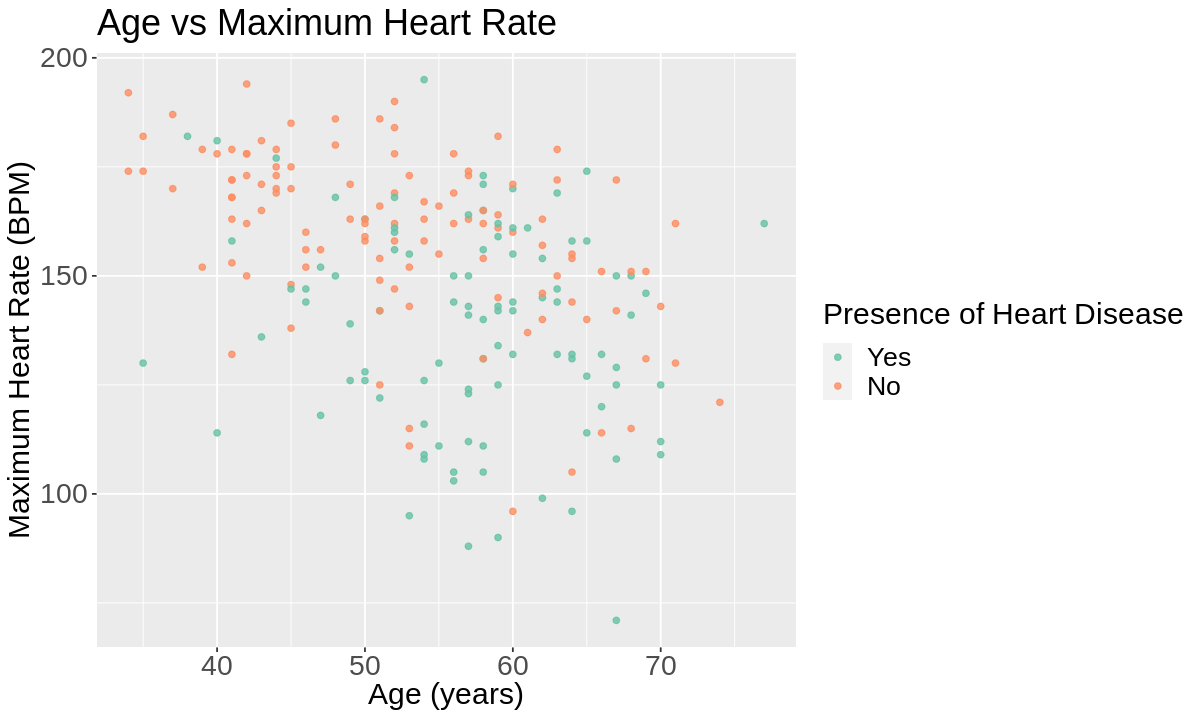

In [15]:
#Plotting a scatter plot with Age vs Maximum Heart Rate
age_heart <- ggplot(heart_train, aes(x = age, y = maxheartrate, 
                                       color = diagnosis))                  +
              geom_point(alpha = 0.8)                                       +
              labs(x = "Age (years)", y = "Maximum Heart Rate (BPM)", 
                   color = "Presence of Heart Disease")                     +
              ggtitle("Age vs Maximum Heart Rate")                          +
              theme(text = element_text(size = 20),
                    axis.text.x = element_text(size = 17),
                    axis.text.y = element_text(size = 17),
                    title       = element_text(size = 18))                  +
              scale_color_brewer(palette = "Set2")

options(repr.plot.width = 10, repr.plot.height = 6)
age_heart

*Figure 2.5. Age vs Maximum heart rate scatter plot based on Cleveland's dataset.*

Based on the plots above, we expect age, sex, number of major vessels colored by fluoroscopy, ST depression induced by exercise, and maximum heart rate to be able to predict the presence of heart disease. More specifically, older people, with high ST depression, low maximum heart rate, and a high number of major vessels are more prone to be diagnosed positively with heart disease. In figure 2.3, it can be seen that there is a significant difference between the appearance of heart disease in women and men, with the latter being much more prone.

Furthermore, in the density plots, the density curves for the positive diagnosis and the negative diagnosis have minimal overlapping, indicating a signifcant difference of values among both. For example, in the age density plot, most of the density and the peak of the curve for positive diagnosis is found in the right side, where older ages lie. It is the opposite situation for the curve for negative diagnosis. Therefore, older people are more prone of having heart disease. Moreover, in figure 2.5 it can be seen that maximum heart rate decreases with age, and heart disease risk increases.

However, the plot for fasting blood sugar shows that people with over 120 mg/dl are more prone to have heart disease, but the difference is quite slight. Despite the grave implications a high blood sugar level might have on the heart, we hypothesize it might not be a good predictor. Therefore, it has been decided that fasting blood sugar will not be chosen as a predictor. Thus, our original predictive question was changed into the following: what is a person's heart diagnosis based on their age, sex, ST depression induced by exercise, number of major vessels and maximum heart rate?

In [15]:
heart_training <- heart_train %>%
select(-fastingbs)

heart_testing <- heart_test %>%
select(-fastingbs)

### 2.3. Classification analysis

For creating the model, the testing set created earlier will be tested to predict the diagnosis based on the variables and see its accuracy. Since it is a small dataset, cross-validation must also be performed. The training set will be divided into 5 folds and the results for neighbors and mean accuracy will be plotted to find the most suitable value of $k$. The $k$ value is the one with the highest accuracy. Once the value of $k$ has been found, the classifier model will be retrained with that value. Lastly, the $k$-nearest neighbor model will be used to predict the diagnosis of patients in the test set. Based on how many are correctly predicted, this will dictate the accuracy of the model since it is to see how well it performs with data that it has not been trained with.

In [16]:
#Creating the recipe, the vfold and the model specification.
set.seed(11)

heart_recipe  <- recipe(diagnosis ~ ., data = heart_training)               %>%
                 step_scale(all_predictors())                               %>%
                 step_center(all_predictors())

heart_vfold   <- vfold_cv(heart_training, v = 5, strata = diagnosis)

knn_spec      <- nearest_neighbor(weight_func = "rectangular", 
                                  neighbors   = tune())                     %>%
                 set_engine("kknn")                                         %>%
                 set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [17]:
#Creating the workflow, setting it to test the k values specified in k_vals.
#After, collecting the metrics and filtering for the accuracy.
set.seed(11)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))
heart_results <- workflow()                                                 %>%
                 add_recipe(heart_recipe)                                   %>%
                 add_model(knn_spec)                                        %>%
                 tune_grid(resamples = heart_vfold, grid = k_vals)          %>%
                 collect_metrics()

accuracy      <- heart_results                                              %>%
                 filter(.metric == "accuracy")
head(accuracy)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6911217,5,0.02481673,Model01
2,accuracy,binary,0.6911217,5,0.02481673,Model02
3,accuracy,binary,0.7520460,5,0.01727200,Model03
4,accuracy,binary,0.7520460,5,0.01727200,Model04
5,accuracy,binary,0.7848256,5,0.02317540,Model05
6,accuracy,binary,0.7848256,5,0.02317540,Model06


*Figure 3.1. First six rows of the metrics collected from the performed crossvalidation.*

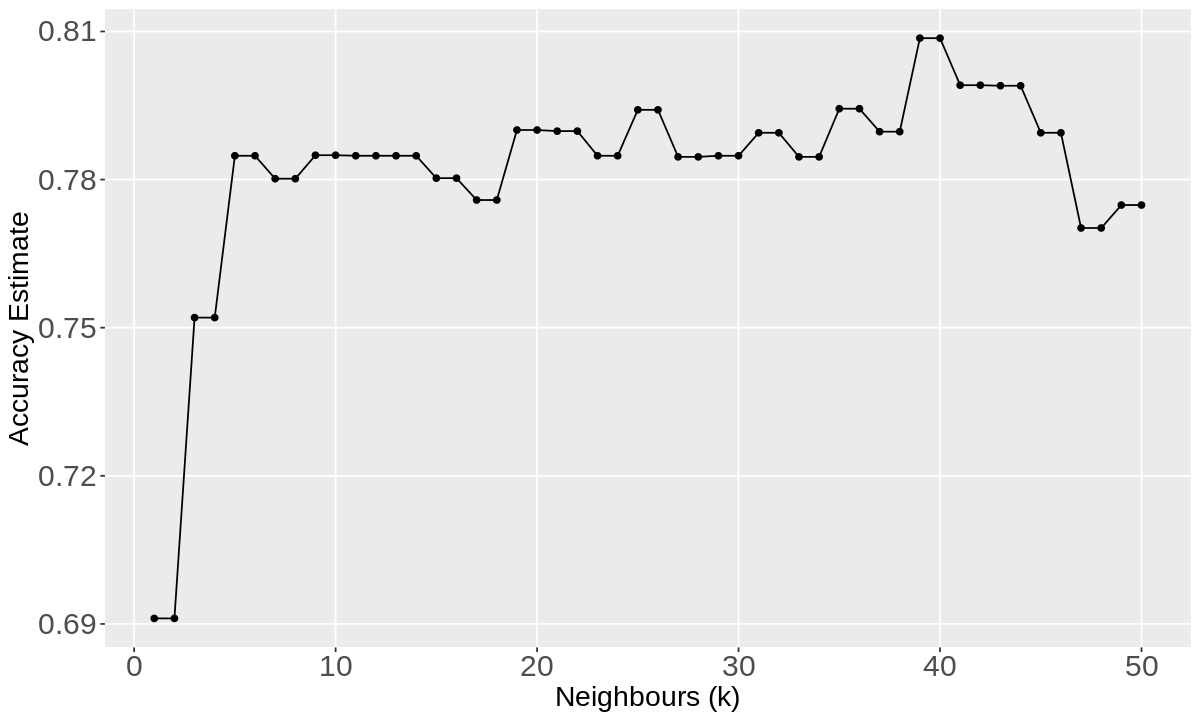

In [18]:
#Creating a plot of neighbors vs accuracy to determine optimal k.
accuracy_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))             +
                  geom_point()                                              +
                  geom_line()                                               +
                  labs(x = "Neighbours (k)", y = "Accuracy Estimate")           +
                  theme(text        = element_text(size = 17),
                        axis.text.x = element_text(size = 18),
                        axis.text.y = element_text(size = 18),
                        panel.grid.minor = element_blank())

options(repr.plot.width = 10, repr.plot.height = 6)
accuracy_plot

*Figure 3.2. Accuracy Estimate vs Number of Neighbors (k) line and point plot.*

Based on the above plot, the optimal $k$ is $k$ = 39. Therefore, the model is retrained based on this.

In [19]:
#Creating a new model specification, with 39 neighbors. A new workflow is also created.
set.seed(11)

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 39) %>%
              set_engine("kknn")                                            %>%
              set_mode("classification")

heart_fit  <- workflow()                                                    %>%
              add_recipe(heart_recipe)                                      %>%
              add_model(heart_spec)                                         %>%
              fit(data = heart_training)
heart_spec
heart_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 39
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~39, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2047619
Best kernel: rectangular
Best k: 39

In [20]:
#The testing set is predicted. The metrics are collected, filtered for accuracy
#and finally, an accuracy table and accuracy number is gotten.
heart_predictions <- predict(heart_fit, heart_testing)                      %>%
                     bind_cols(heart_testing)

heart_metrics     <- heart_predictions                                      %>%
                     metrics(truth = diagnosis, estimate = .pred_class)     %>%
                     filter(.metric == "accuracy")

heart_conf_mat    <- heart_predictions                                      %>%
                     conf_mat(truth = diagnosis, estimate = .pred_class)

number_accuracy   <- heart_predictions                                      %>%
                     metrics(truth = diagnosis, estimate = .pred_class)     %>%
                     filter(.metric == "accuracy")                          %>%
                     select(.estimate)                                      %>%
                     pull()

number_accuracy
heart_conf_mat

[1] 0.7977528

          Truth
Prediction Yes No
       Yes  28  5
       No   13 43

*Figure 3.3. Accuracy table with the number of correctly and uncorrectly predicted diagnosis.*

The model, when predicting the testing set, it has a 79.77% accuracy. 28 values were correctly diagnosed as positive of heart disease and 43 values were correctly diagnosed as negative of heart disease. 5 values were incorrectly diagnosed as positive of heart disease and 13 values were incorrectly diagnosed as negative of heart disease.

### 2.4. Visualization of the performed analysis

Using the generated predictions table, visualizations of the performed analysis are plotted to determine further insight about the created model and its implications. The first six visualizations are scatter plots of the four numeric predictors, visualized in pairs, with the predicted values faded in the background. The last visualizations are two bar plots of correctly predicted values and incorrectly predicted values based on sex.

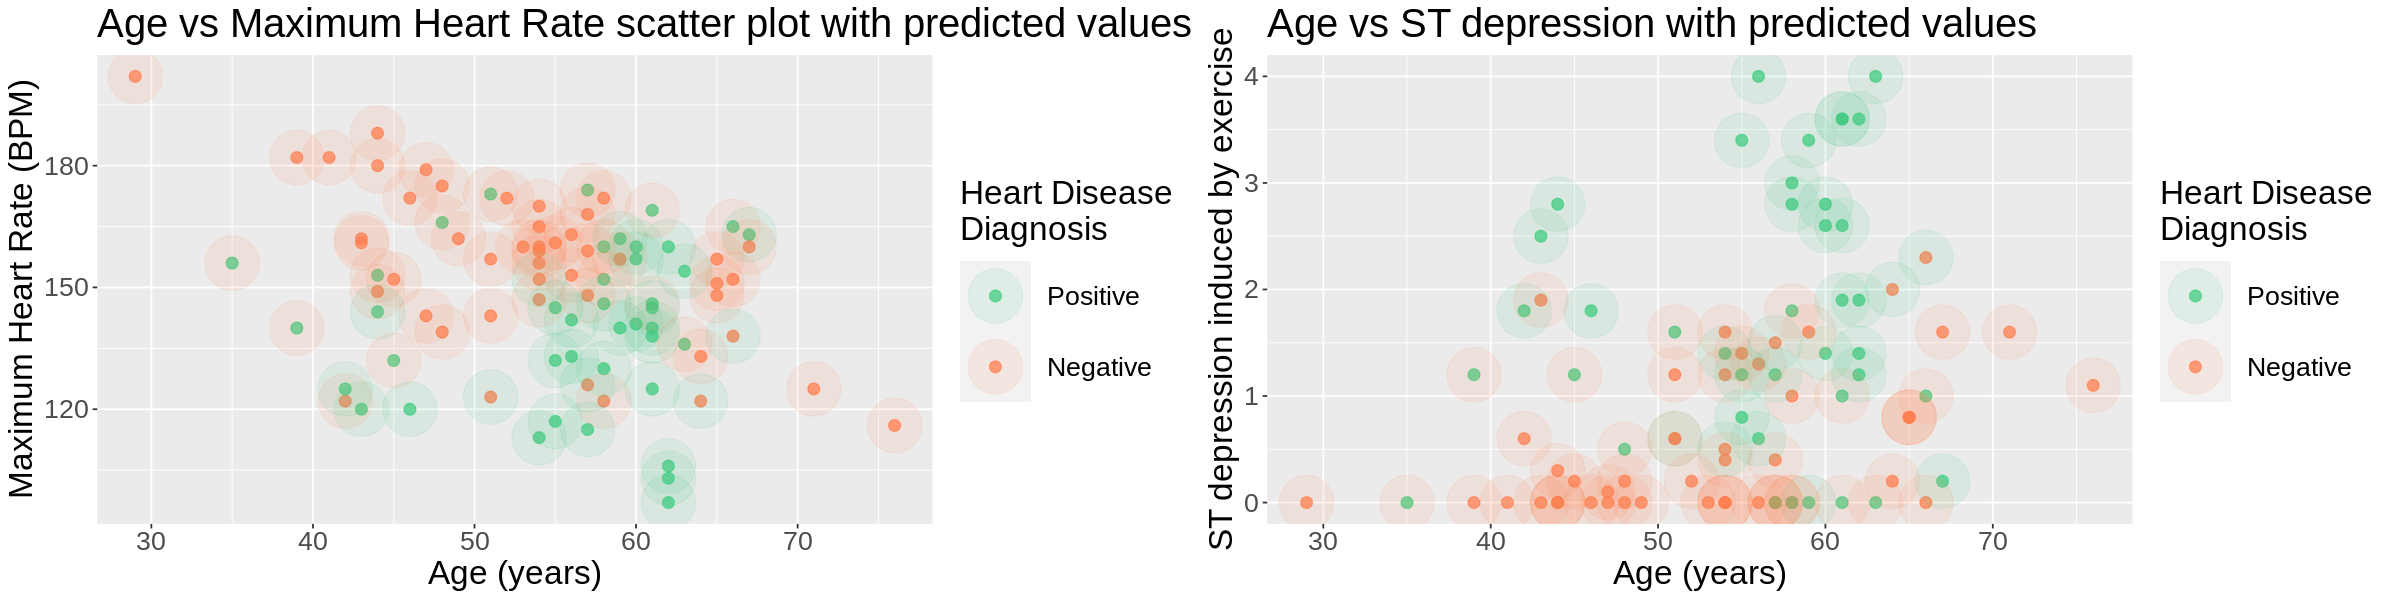

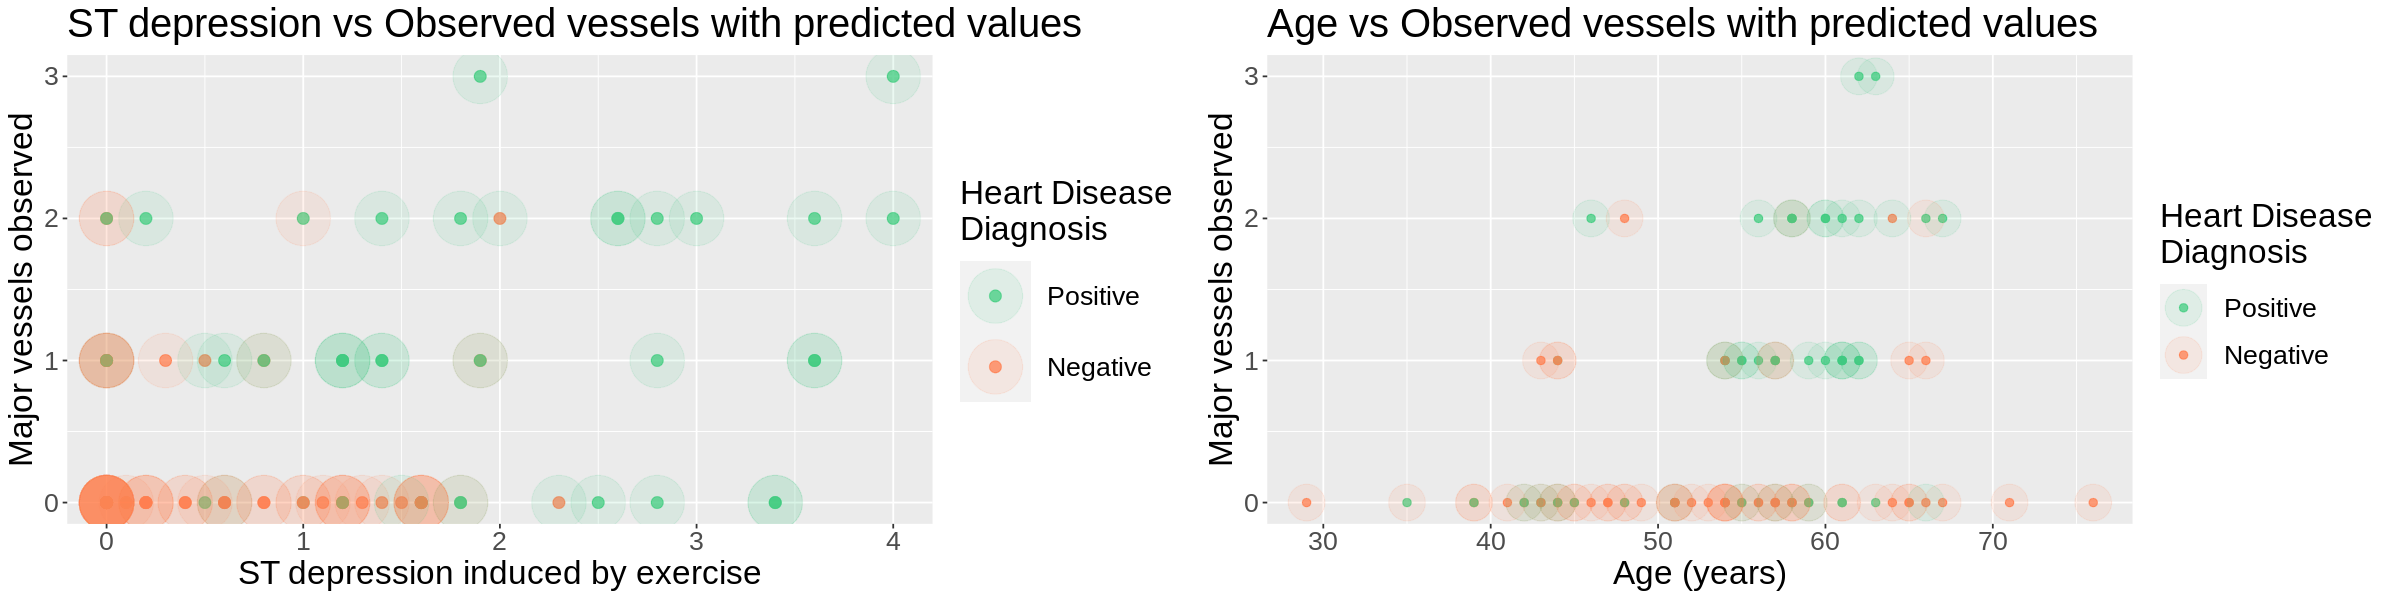

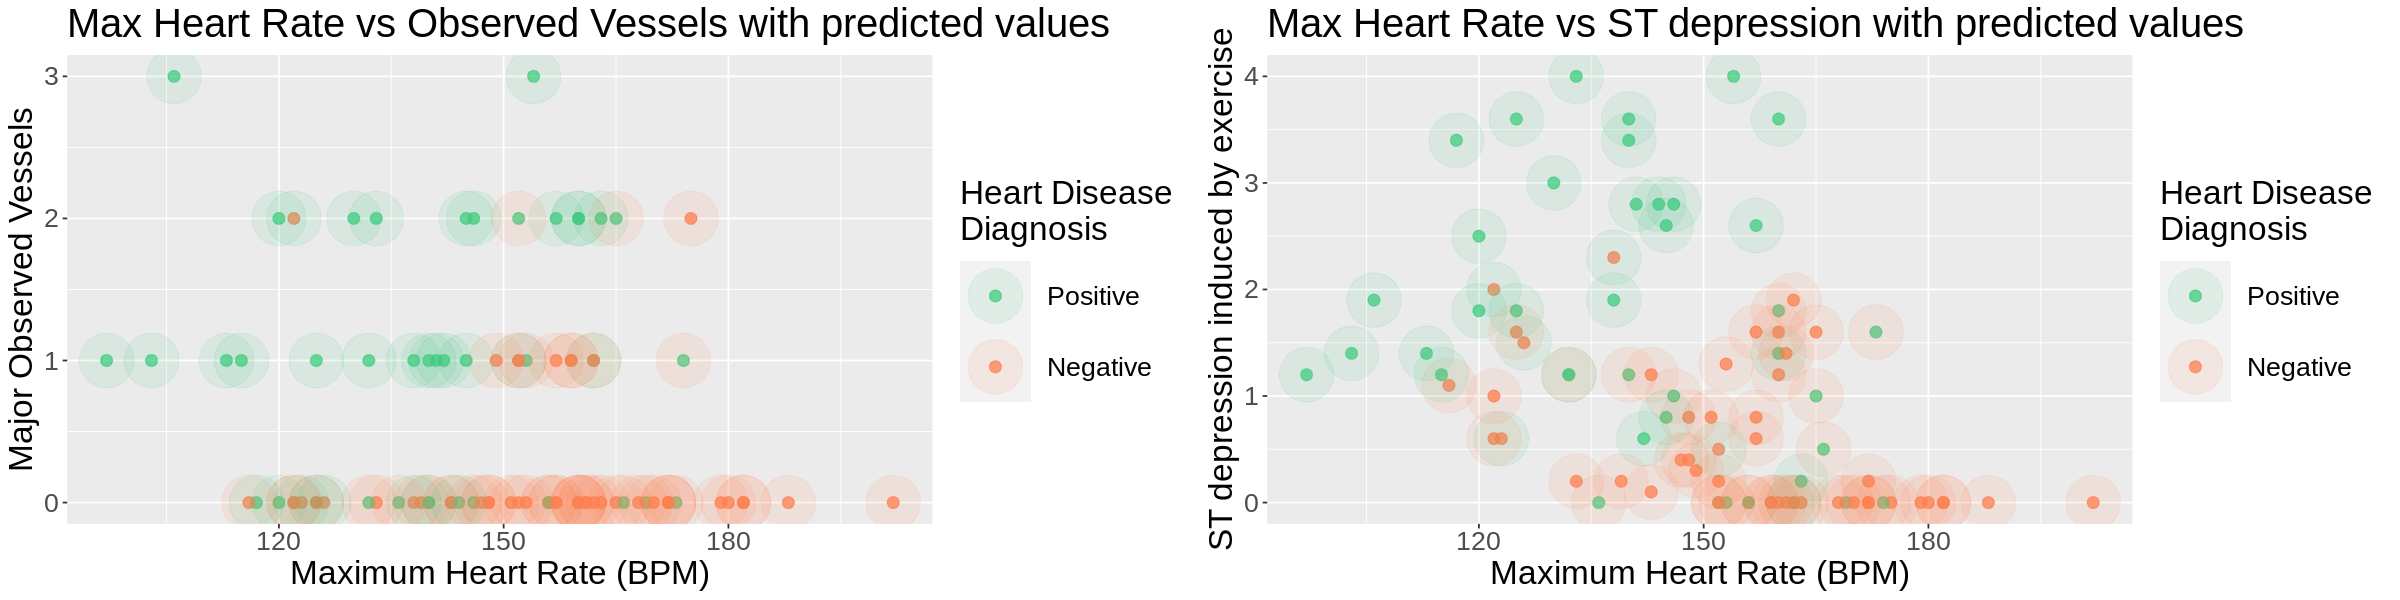

In [25]:
options(repr.plot.width = 20, repr.plot.height = 5) 

#Creating a scatter plot of Age vs Max Heart Rate with
#the predicted values as faded points.
agerate_plot <- ggplot() +
geom_point(data = heart_testing, 
           mapping = aes(x = age,
                         y = maxheartrate,
                         color = diagnosis),
           alpha = 0.75,
          size = 3) +
geom_point(data = heart_predictions, 
            mapping = aes(x = age,
                          y = maxheartrate,
                          color = .pred_class), 
             alpha = 0.10, 
             size = 15) +
  labs(color = "Heart Disease \nDiagnosis", 
       x = "Age (years)", 
       y = "Maximum Heart Rate (BPM)",
      title = "Age vs Maximum Heart Rate scatter plot with predicted values") +
 scale_color_manual(labels = c("Positive", "Negative"), 
                     values = c("seagreen3", "coral")) +
  theme(text = element_text(size = 20))

#Creating a scatter plot of Age vs ST depression with
#the predicted values as faded points.
agepeak_plot <- ggplot() +
geom_point(data = heart_testing, 
           mapping = aes(x = age,
                         y = oldpeak,
                         color = diagnosis),
           alpha = 0.75,
          size = 3) +
geom_point(data = heart_predictions, 
            mapping = aes(x = age,
                          y = oldpeak,
                          color = .pred_class), 
             alpha = 0.10, 
             size = 15) +
  labs(color = "Heart Disease \nDiagnosis", 
       x = "Age (years)", 
       y = "ST depression induced by exercise",
      title = "Age vs ST depression with predicted values") +
 scale_color_manual(labels = c("Positive", "Negative"), 
                     values = c("seagreen3", "coral")) +
  theme(text = element_text(size = 20))

#Creating a scatter plot of Age vs Observed Vessels with
#the predicted values as faded points.
agevessel_plot <- ggplot() +
geom_point(data = heart_testing, 
           mapping = aes(x = age,
                         y = nmajorvessels,
                         color = diagnosis),
           alpha = 0.75,
          size = 2) +
geom_point(data = heart_predictions, 
            mapping = aes(x = age,
                          y = nmajorvessels,
                          color = .pred_class), 
             alpha = 0.10, 
             size = 10) +
  labs(color = "Heart Disease \nDiagnosis", 
       x = "Age (years)", 
       y = "Major vessels observed",
      title = "Age vs Observed vessels with predicted values") +
 scale_color_manual(labels = c("Positive", "Negative"), 
                     values = c("seagreen3", "coral")) +
  theme(text = element_text(size = 20))

#Creating a scatter plot of ST depression vs Observed Vessels with
#the predicted values as faded points.
peakvessels_plot <- ggplot() +
geom_point(data = heart_testing, 
           mapping = aes(x = oldpeak,
                         y = nmajorvessels,
                         color = diagnosis),
           alpha = 0.75,
          size = 3) +
geom_point(data = heart_predictions, 
            mapping = aes(x = oldpeak,
                          y = nmajorvessels,
                          color = .pred_class), 
             alpha = 0.10, 
             size = 15) +
  labs(color = "Heart Disease \nDiagnosis", 
       x = "ST depression induced by exercise", 
       y = "Major vessels observed",
      title = "ST depression vs Observed vessels with predicted values") +
 scale_color_manual(labels = c("Positive", "Negative"), 
                     values = c("seagreen3", "coral")) +
  theme(text = element_text(size = 20))

#Creating a scatter plot of ST depression vs Max Heart Rate with
#the predicted values as faded points.
ratepeak_plot <- ggplot() +
geom_point(data = heart_testing, 
           mapping = aes(x = maxheartrate,
                         y = oldpeak,
                         color = diagnosis),
           alpha = 0.75,
          size = 3) +
geom_point(data = heart_predictions, 
            mapping = aes(x = maxheartrate,
                          y = oldpeak,
                          color = .pred_class), 
             alpha = 0.10, 
             size = 15) +
  labs(color = "Heart Disease \nDiagnosis", 
       x = "Maximum Heart Rate (BPM)", 
       y = "ST depression induced by exercise",
      title = "Max Heart Rate vs ST depression with predicted values") +
 scale_color_manual(labels = c("Positive", "Negative"), 
                     values = c("seagreen3", "coral")) +
  theme(text = element_text(size = 20))

#Creating a scatter plot of Observed vessels vs Max Heart Rate with
#the predicted values as faded points.
ratevessels_plot <- ggplot() +
geom_point(data = heart_testing, 
           mapping = aes(x = maxheartrate,
                         y = nmajorvessels,
                         color = diagnosis),
           alpha = 0.75,
          size = 3) +
geom_point(data = heart_predictions, 
            mapping = aes(x = maxheartrate,
                          y = nmajorvessels,
                          color = .pred_class), 
             alpha = 0.10, 
             size = 15) +
  labs(color = "Heart Disease \nDiagnosis", 
       x = "Maximum Heart Rate (BPM)", 
       y = "Major Observed Vessels",
      title = "Max Heart Rate vs Observed Vessels with predicted values") +
 scale_color_manual(labels = c("Positive", "Negative"), 
                     values = c("seagreen3", "coral")) +
  theme(text = element_text(size = 20))

plot_grid(agerate_plot, agepeak_plot, ncol = 2)
plot_grid(peakvessels_plot, agevessel_plot, ncol = 2)
plot_grid(ratevessels_plot, ratepeak_plot, ncol = 2)

*Figure 4.1. Scatter plots of the numeric predictors in pairs with the predicted values as faded points.*

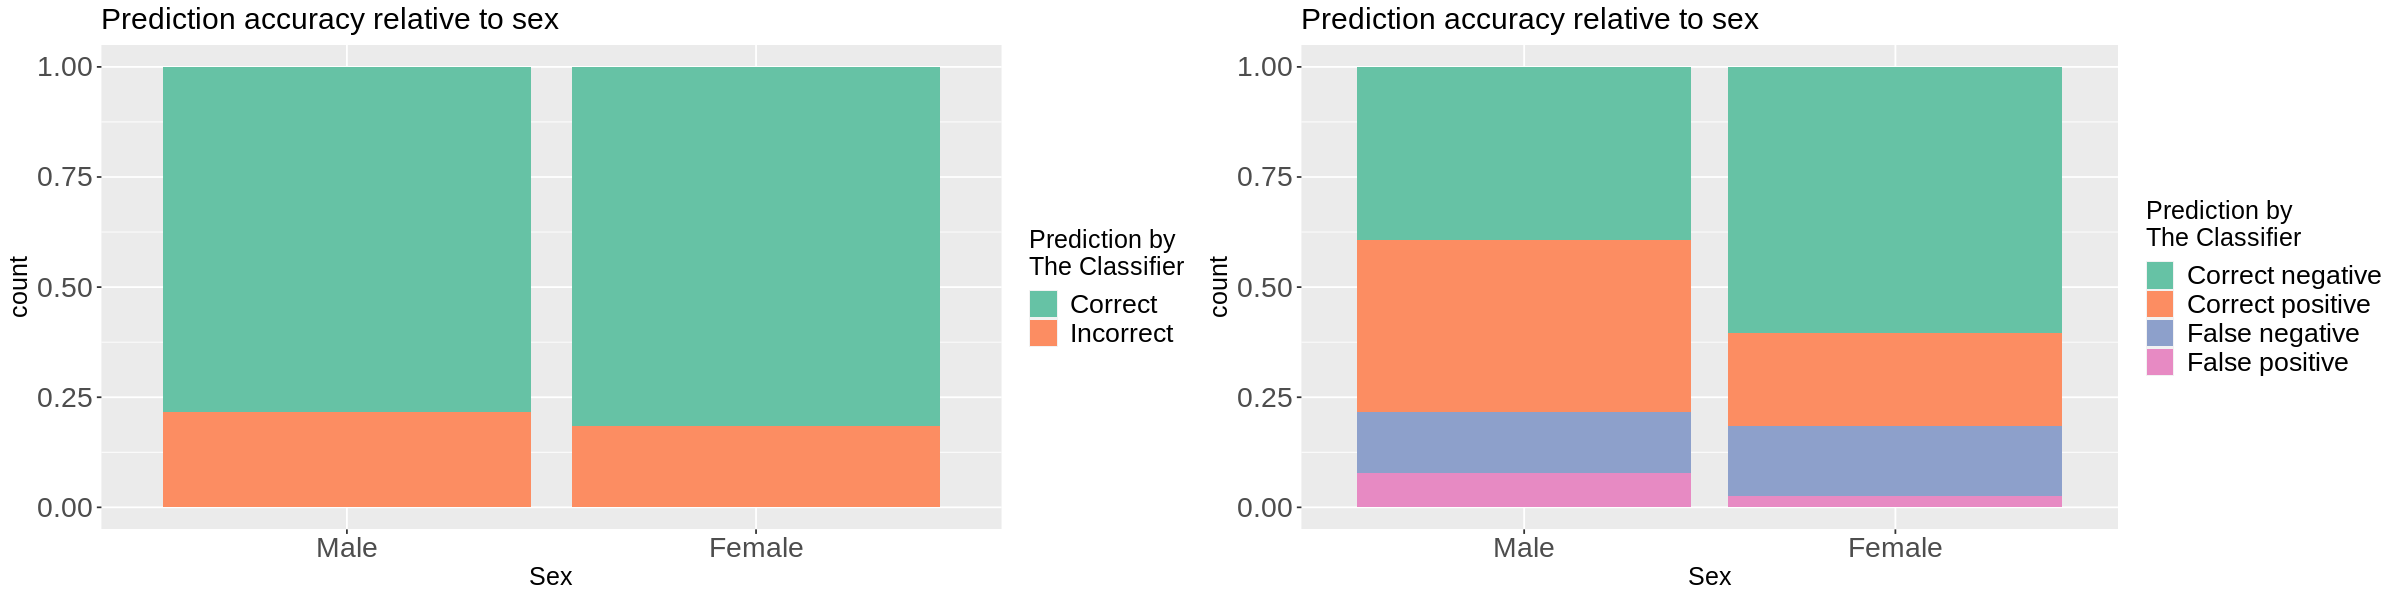

In [47]:
#Bar plot 1: creating different tables with their corresponding prediction.
heart_falsepos1 <- heart_predictions %>%
select(.pred_class, sex, diagnosis) %>%
filter(.pred_class == "Yes", diagnosis == "No") %>%
mutate(prediction = "Incorrect")

heart_falseneg1 <- heart_predictions %>%
select(.pred_class, sex, diagnosis) %>%
filter(.pred_class == "No", diagnosis == "Yes") %>%
mutate(prediction = "Incorrect")

heart_neg1 <- heart_predictions %>%
select(.pred_class, sex, diagnosis) %>%
filter(.pred_class == "No", diagnosis == "No") %>%
mutate(prediction = "Correct")

heart_pos1 <- heart_predictions %>%
select(.pred_class, sex, diagnosis) %>%
filter(.pred_class == "Yes", diagnosis == "Yes") %>%
mutate(prediction = "Correct")

#Binding the tables together and recoding sex into factor.
heart_sexprediction1 <- bind_rows(heart_falsepos1, heart_falseneg1, heart_neg1, heart_pos1)

heart_sexprediction1_0 <- heart_sexprediction1 %>%
mutate(sex = recode_factor(sex, `1` = "Male", 
                                `0` = "Female" ))


#Creating the bar plot
sexprediction_plot <- ggplot(heart_sexprediction1_0, aes(x = sex, fill = prediction))  +
             geom_bar(position = "fill")                                    +
             labs(x = "Sex", fill = "Prediction by \nThe Classifier")       +
             ggtitle("Prediction accuracy relative to sex")                 +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")

#Bar plot 2: Creating different tables with their corresponding prediction.
heart_falsepos2 <- heart_predictions %>%
select(.pred_class, sex, diagnosis) %>%
filter(.pred_class == "Yes", diagnosis == "No") %>%
mutate(prediction = "False positive")

heart_falseneg2 <- heart_predictions %>%
select(.pred_class, sex, diagnosis) %>%
filter(.pred_class == "No", diagnosis == "Yes") %>%
mutate(prediction = "False negative")

heart_neg2 <- heart_predictions %>%
select(.pred_class, sex, diagnosis) %>%
filter(.pred_class == "No", diagnosis == "No") %>%
mutate(prediction = "Correct negative")

heart_pos2 <- heart_predictions %>%
select(.pred_class, sex, diagnosis) %>%
filter(.pred_class == "Yes", diagnosis == "Yes") %>%
mutate(prediction = "Correct positive")

#Binding the tables together and recoding sex into factor.
heart_sexprediction2 <- bind_rows(heart_falsepos2, heart_falseneg2, heart_neg2, heart_pos2)

heart_sexprediction2_0 <- heart_sexprediction2 %>%
mutate(sex = recode_factor(sex, `1` = "Male", 
                                `0` = "Female" ))


#Creating the bar plot
sexprediction_plot2 <- ggplot(heart_sexprediction2_0, aes(x = sex, fill = prediction))  +
             geom_bar(position = "fill")                                    +
             labs(x = "Sex", fill = "Prediction by \nThe Classifier")       +
             ggtitle("Prediction accuracy relative to sex")                 +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")
plot_grid(sexprediction_plot, sexprediction_plot2, ncol = 2)

*Figure 4.2. Bar plots of the prediction accuracy of the model based on sex.*

## 3. Discussion

The objective of this classification problem was to predict an individual’s heart health diagnosis (presence or absence of heart disease), as accurately as possible, by using the variables of age, sex, maximum heart rate, ST depression induced by exercise, and the number of observed major vessels. These are the five predictors that were selected out of the 14 variables included in the original dataset of patients, as they were some of the variables that produced the most distinguishable numerical values between the individuals classified as with or without a heart disease diagnosis.

This exploratory analysis was carried out by first splitting up the data into a training and testing set, which was necessary in order to properly test the accuracy of the final model later on. The mean values of each predictive variable were found for both possible diagnoses and some were equally represented as a bar graph in order to further confirm if the predictors were well chosen. With these steps completed, the data was visually portrayed as a line distribution graph, coloured in to indicate classified group; it produced two traces that depicted the density of individuals with or without heart disease across all the predictive values. The observation of these visualizations lead to the conclusion that individuals who are older in age, have a lower maximum heart rate, higher ST depression induced by exercise, as well as a higher number of major vessels have a higher probability of receiving a positive diagnosis of heart disease. Furthermore, amongst these individuals that possess an increased probability, males are ≅ 45% more likely to be diagnosed with heart disease in comparison to women. These conclusions were further cemented with the graphs generated in figure 4.1.

Classification analysis was done through a cross validation of 5-folds that allowed the determination of the $k$-nearest neighbour value to the highest degree of accuracy–found to be $k$ = 39. Having determined this specification, the model was then re-trained with this basis and capable of predicting the diagnosis of patients in the testing set. The results of the predictions made by our $k$-nearest neighbour model on the data it had not encountered before (i.e been trained on) showed that it had an overall accuracy of 79.77%; in terms of a relative break down, 84.85% of  the diagnoses predicting the presence of heart disease were correct, and 76.79% of the predictions claiming the absence were also correct.

Moreover, the results of the model's predictions were visualized in figures 4.1 and 4.2. It can be seen that the observations that were incorrectly diagnosed (i.e. the point's color is different from its faded color in the background) are the points that are found to be further away from where the majority of points of its category are. A trend can be seen in each graph about where the majority of points of positive diagnosis are, and viceversa for negative diagnosis. In figure 4.2, it can be seen that the percentage of correct predictions was slightly higher in males, but not significant enough. However, females were shown to have a higher percentage of correctly predicted negative diagnosis than males. For males, they had a higher percentage of correctly predicted positive diagnosis and false positive diagnosis than females.

These findings are what was expected. The five predictors chosen are shown to be correlated to heart disease, however, they are not certain indicators. Furthermore, the human body is complex and it is difficult to ascertain with 100% accuracy a diagnosis, therefore, 79.77% accuracy was to be expected. However, given the objective of the exploratory and classification analysis was to distinguish between states of medical health, it would have been ideal for the accuracy to be higher since a misdiagnosis can lead to a range of implications,varying in severity, for medical practitioners. Due to the consequential nature of a misdiagnosis, medical professionals require sophisticated classification technology/methodologies precise enough to provide a conclusion within the 95% confidence interval.

These findings, despite being slightly inaccurate, could impact the medical world. Considering that the accuracy of this model is below eighty percent, a doctor would likely not consider this classification system when consulting an individual showing minimal or inconsistent predictors of heart disease, as there is enough of a probability the patient would fall in the frame of uncertainty. However, this model could be useful in confirming a doctor’s predictions regarding an individual’s heart health. This patient in question would likely already exhibit the predictors of a heart disease diagnosis, and potentially even the symptoms of cardiovascular distress itself. In this given situation, the model could be used for further confirmation. 

These findings could leach to questions such as: what other predictors that were not chosen could have been a good choice? What could improve the model's accuracy? Why was fasting blood sugar shown to not be a good predictor? In order to question what could be improved in this model for the future, one must consider if  a significantly complex classification question could have been oversimplified. The model’s accuracy can be potentially improved through further exploration of relationship between the variables. As only 5 out of 14 predictor variables were chosen from the original dataset analysis; perhaps integrating more predictors can provide a more holistic overview to the analysis.

## 4. References

Centers for Disease Control and Prevention, National Center for Health Statistics. (2020). National Vital Statistics System: public use data file documentation: mortality multiple cause-of-death micro-data files.Accessed April 9th, 2020. https://www.cdc.gov/nchs/data/dvs/Multiple-Cause-Record-Layout-2020.pdf

Clarke, M., Ewings, P., Hanna, T., Dunn, L., Girling, T., & Widdison, A. (2009). How accurate are doctors, nurses and medical students at predicting life expectancy?. *European Journal Of Internal Medicine*, 20(6), 640-644. doi: 10.1016/j.ejim.2009.06.009

Detrano, R., Janosi, A., Steinbrunn, W., & Pfisterer, M. (1989). *Heart Disease Data Set* [Cleveland Data Set]. UCI Machine Learning Repository. Retrieved from: https://archive.ics.uci.edu/ml/datasets/heart+disease